In [57]:
import numpy as np
from sympy import *
import matplotlib.pyplot as plt
from dynamics import Dynamics
import pandas as pd
import os
import time

In [58]:
# ============================================================
# Run "truth" simulation with very small Δt
# ============================================================

truth_path = "../data/truth_reference.csv"

if os.path.exists(truth_path):
    print("Truth run exists, done!")
    truth = pd.read_csv(truth_path)
else:
    dt_truth = 0.002  # very small step, e.g.
    xhat0 = np.array([0,0,0,0,0,0,1,0,0,0])
    dyn = Dynamics(dt=dt_truth, x0=xhat0)
    dyn.setup_eom()
    dyn.run_rk4(xhat0)

    # Convert results to DataFrame
    data = np.column_stack((dyn.ts, np.array(dyn.states)))
    cols = ['t', 'w1','w2','w3','v1','v2','v3','qw','qx','qy','qz']
    df = pd.DataFrame(data, columns=cols)

    # Save to CSV
    df.to_csv(truth_path, index=False)
    print("Saved truth data to truth_reference.csv")




Truth run exists, done!


In [60]:
# ============================================================
# Configuration
# ============================================================

# Folder for saved simulation data
save_dir = "../data/rk4_runs"
os.makedirs(save_dir, exist_ok=True)

# Time steps to simulate
dt_values = np.array([0.4, 0.2, 0.1, 0.05, 0.025])  
xhat0 = np.array([0,0,0,0,0,0,1,0,0,0])

# ============================================================
# Function to run and save a single simulation
# ============================================================

def run_and_save(dt):
    filename = f"rk4_dt{dt:.3f}".replace('.', 'p') + ".csv"
    filepath = os.path.join(save_dir, filename)

    # Skip if it already exists
    if os.path.exists(filepath):
        print(f"{filename} already exists, skipping simulation.")
        return

    print(f"\nRunning simulation for Δt = {dt:.4f} s ...")
    dynamics = Dynamics(dt=dt, x0=xhat0)
    dynamics.setRocketParams(
        I_0=0.327,
        I_f=0.287,
        I_3=0.0035,
        x_CG_0=0.675,
        x_CG_f=0.635,
        m_0=2.944,
        m_f=2.589,
        m_p=0.355,
        d=0.0787,
        L_ne=1.17,
        Cnalpha_rocket=0.207,
        t_motor_burnout=1.971,
        t_launch_rail_clearance=0.308
    )
    dynamics.setFinParams(
        N=4,
        Cr=0.18,
        Ct=0.0597,
        s=0.0876,
        Cnalpha_fin=2.72025,
        delta=1.0
    )
    dynamics.setup_eom()

    start = time.time()
    dynamics.run_rk4(xhat0)
    runtime = time.time() - start

    data = np.column_stack((dynamics.ts, np.array(dynamics.states)))
    cols = ['t', 'w1','w2','w3','v1','v2','v3','qw','qx','qy','qz']
    df = pd.DataFrame(data, columns=cols)
    df.to_csv(filepath, index=False)

    print(f"Saved {filename} ({len(dynamics.ts)} steps, runtime {runtime/60:.1f} min)")
    return filepath

# ============================================================
# Run simulations for each dt and save results
# ============================================================

for dt in dt_values:
    run_and_save(dt)

print("\nAll simulations complete.")


rk4_dt0p400.csv already exists, skipping simulation.
rk4_dt0p200.csv already exists, skipping simulation.
rk4_dt0p100.csv already exists, skipping simulation.
rk4_dt0p050.csv already exists, skipping simulation.
rk4_dt0p025.csv already exists, skipping simulation.

All simulations complete.


w3: Δt=0.0500 → err=2.210e-02
w3: Δt=0.1000 → err=7.952e-03
w3: Δt=0.2000 → err=2.305e+10
w3: Δt=0.4000 → err=1.450e+26
v2: Δt=0.0500 → err=2.037e-02
v2: Δt=0.1000 → err=7.879e-03
v2: Δt=0.2000 → err=1.982e-02
v2: Δt=0.4000 → err=3.978e-02


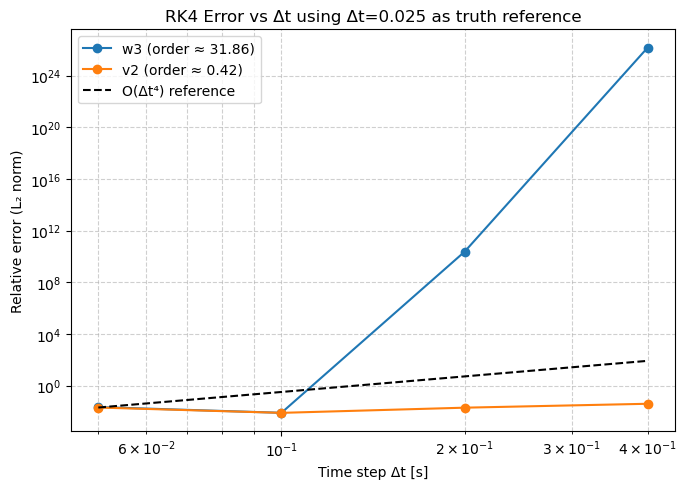

In [65]:
# ============================================================
# Configuration
# ============================================================

data_dir = "../data/rk4_runs"
truth_path = os.path.join(data_dir, "rk4_dt0p025.csv")  # truth
dt_values = [0.05, 0.1, 0.2, 0.4]                      # coarser timesteps
metrics = [("w3", 2), ("v2", 5)]                       # (label, column index)

# Define analysis window (use full)
t_burnout = 1.971
t_apogee  = 13.571
window = (0.0, t_apogee)

# ============================================================
# Load truth reference
# ============================================================
truth = pd.read_csv(truth_path)
t_ref = truth["t"].values
states_ref = truth.iloc[:, 1:].values  # w1,w2,w3,v1,v2,v3,qw,qx,qy,qz

# Helper function
def relative_error(y, y_ref, t, t_ref, t0, t1):
    """Compute L2 relative error between y and interpolated truth."""
    y_ref_interp = np.interp(t, t_ref, y_ref)
    mask = (t >= t0) & (t <= t1)
    if not np.any(mask): 
        return np.nan
    y, y_ref_interp = y[mask], y_ref_interp[mask]
    return np.linalg.norm(y - y_ref_interp) / np.linalg.norm(y_ref_interp)

# ============================================================
# Compute and plot all on one figure
# ============================================================
plt.figure(figsize=(7,5))

for metric_name, col in metrics:
    y_ref = states_ref[:, col]
    errs = []

    for dt in dt_values:
        file_path = os.path.join(data_dir, f"rk4_dt{dt:.3f}".replace('.', 'p') + ".csv")
        if not os.path.exists(file_path):
            print(f"⚠ Missing {file_path}, skipping.")
            errs.append(np.nan)
            continue

        df = pd.read_csv(file_path)
        t = df["t"].values
        y = df.iloc[:, col+1].values  # +1 to skip 't'

        err = relative_error(y, y_ref, t, t_ref, *window)
        errs.append(err)
        print(f"{metric_name}: Δt={dt:.4f} → err={err:.3e}")

    # Convert to arrays and compute slope
    errs = np.array(errs)
    valid = np.isfinite(errs) & (errs > 0)
    if valid.sum() >= 2:
        order = np.polyfit(np.log(np.array(dt_values)[valid]), np.log(errs[valid]), 1)[0]
    else:
        order = np.nan

    plt.loglog(dt_values, errs, "o-", label=f"{metric_name} (order ≈ {order:.2f})")

# Reference O(Δt⁴) line
if len(dt_values) >= 2 and np.isfinite(errs[0]):
    ref_line = errs[0] * (np.array(dt_values)/dt_values[0])**4
    plt.loglog(dt_values, ref_line, "k--", label="O(Δt⁴) reference")

# Style and labels
plt.xlabel("Time step Δt [s]")
plt.ylabel("Relative error (L₂ norm)")
plt.title("RK4 Error vs Δt using Δt=0.025 as truth reference")
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


w3: Δt=0.025 → err=5.505e-02
w3: Δt=0.050 → err=7.015e-02
w3: Δt=0.100 → err=5.998e-02
w3: Δt=0.200 → err=2.249e+10
w3: Δt=0.400 → err=1.415e+26
v3: Δt=0.025 → err=4.481e-03
v3: Δt=0.050 → err=1.838e-02
v3: Δt=0.100 → err=5.400e-03
v3: Δt=0.200 → err=1.664e-02
v3: Δt=0.400 → err=3.648e-02


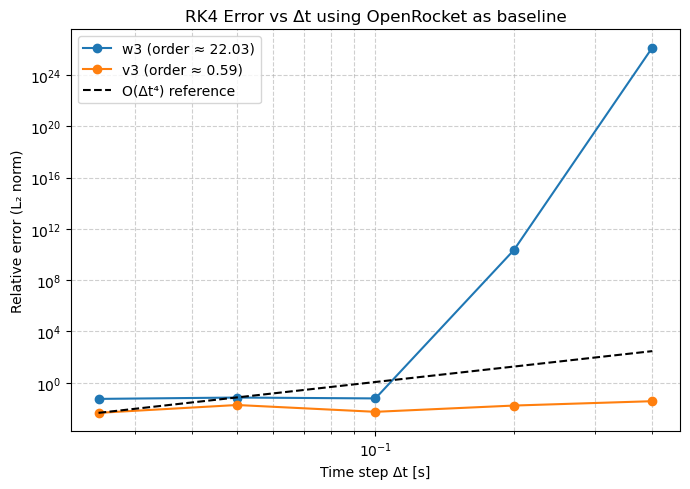

✅ Plot saved to ../data/rk4_error_vs_openrocket.pdf


<Figure size 640x480 with 0 Axes>

In [64]:
# ============================================================
# RK4 Error vs Δt using OpenRocket as baseline (reference)
# ============================================================
# ------------------------------------------------------------
# Configuration
# ------------------------------------------------------------
data_dir = "../data/rk4_runs"
openrocket_path = "../data/openrocket_data2.csv"   # use this as reference
dt_values = [0.025, 0.05, 0.1, 0.2, 0.4]           # RK4 runs
metrics = [
    ("w3", "Roll rate (°/s)", np.pi / 180),        # convert deg/s → rad/s
    ("v3", "Vertical velocity (m/s)", 1.0)         # already m/s
]
t_apogee = 13.571
window = (0.0, t_apogee)
save_path = "../data/rk4_error_vs_openrocket.pdf"

# ------------------------------------------------------------
# Load OpenRocket reference
# ------------------------------------------------------------
or_data = pd.read_csv(openrocket_path)
t_ref = or_data["# Time (s)"].values

# ------------------------------------------------------------
# Helper function
# ------------------------------------------------------------
def relative_error(y, y_ref, t, t_ref, t0, t1):
    """Compute L2 relative error vs reference."""
    y_ref_interp = np.interp(t, t_ref, y_ref)
    mask = (t >= t0) & (t <= t1)
    if not np.any(mask):
        return np.nan
    y, y_ref_interp = y[mask], y_ref_interp[mask]
    return np.linalg.norm(y - y_ref_interp) / np.linalg.norm(y_ref_interp)

# ------------------------------------------------------------
# Compute errors for each metric
# ------------------------------------------------------------
plt.figure(figsize=(7,5))

for metric_name, col_name, scale in metrics:
    y_ref = or_data[col_name].values * scale  # apply unit conversion
    errs = []

    for dt in dt_values:
        file_path = os.path.join(data_dir, f"rk4_dt{dt:.3f}".replace('.', 'p') + ".csv")
        if not os.path.exists(file_path):
            print(f"⚠ Missing {file_path}, skipping.")
            errs.append(np.nan)
            continue

        df = pd.read_csv(file_path)
        t = df["t"].values
        y = df[metric_name].values

        err = relative_error(y, y_ref, t, t_ref, *window)
        errs.append(err)
        print(f"{metric_name}: Δt={dt:.3f} → err={err:.3e}")

    # Estimate observed order
    errs = np.array(errs)
    valid = np.isfinite(errs) & (errs > 0)
    if valid.sum() >= 2:
        order = np.polyfit(np.log(np.array(dt_values)[valid]), np.log(errs[valid]), 1)[0]
    else:
        order = np.nan

    plt.loglog(dt_values, errs, "o-", label=f"{metric_name} (order ≈ {order:.2f})")

# ------------------------------------------------------------
# Add Δt⁴ reference line
# ------------------------------------------------------------
if len(dt_values) >= 2 and np.isfinite(errs[0]):
    ref_line = errs[0] * (np.array(dt_values) / dt_values[0])**4
    plt.loglog(dt_values, ref_line, "k--", label="O(Δt⁴) reference")

# ------------------------------------------------------------
# Final plot formatting
# ------------------------------------------------------------
plt.xlabel("Time step Δt [s]")
plt.ylabel("Relative error (L₂ norm)")
plt.title("RK4 Error vs Δt using OpenRocket as baseline")
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.legend()
plt.tight_layout()

# ------------------------------------------------------------
# Display and save
# ------------------------------------------------------------
plt.show()
plt.savefig(save_path, format="pdf", dpi=300)
print(f"✅ Plot saved to {save_path}")


w3: Δt=0.025 → err=5.505e-02
w3: Δt=0.050 → err=7.015e-02
w3: Δt=0.100 → err=5.998e-02
w3: Δt=0.200 → err=2.249e+10
w3: Δt=0.400 → err=1.415e+26
v3: Δt=0.025 → err=4.481e-03
v3: Δt=0.050 → err=1.838e-02
v3: Δt=0.100 → err=5.400e-03
v3: Δt=0.200 → err=1.664e-02
v3: Δt=0.400 → err=3.648e-02


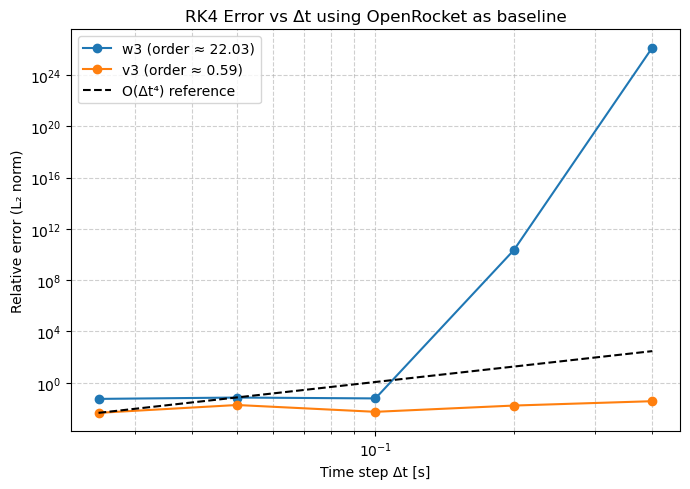

✅ Plot saved to ../data/rk4_error_vs_openrocket.pdf


<Figure size 640x480 with 0 Axes>

In [67]:
# ============================================================
# RK4 Error vs Δt using OpenRocket as baseline (reference)
# ============================================================
# ------------------------------------------------------------
# Configuration
# ------------------------------------------------------------
data_dir = "../data/rk4_runs"
openrocket_path = "../data/openrocket_data2.csv"   # use this as reference
dt_values = [0.025, 0.05, 0.1, 0.2, 0.4]           # RK4 runs
metrics = [
    ("w3", "Roll rate (°/s)", np.pi / 180),        # convert deg/s → rad/s
    ("v3", "Vertical velocity (m/s)", 1.0)         # already m/s
]
t_apogee = 13.571
window = (0.0, t_apogee)
save_path = "../data/rk4_error_vs_openrocket.pdf"

# ------------------------------------------------------------
# Load OpenRocket reference
# ------------------------------------------------------------
or_data = pd.read_csv(openrocket_path)
t_ref = or_data["# Time (s)"].values

# ------------------------------------------------------------
# Helper function
# ------------------------------------------------------------
def relative_error(y, y_ref, t, t_ref, t0, t1):
    """Compute L2 relative error vs reference."""
    y_ref_interp = np.interp(t, t_ref, y_ref)
    mask = (t >= t0) & (t <= t1)
    if not np.any(mask):
        return np.nan
    y, y_ref_interp = y[mask], y_ref_interp[mask]
    return np.linalg.norm(y - y_ref_interp) / np.linalg.norm(y_ref_interp)

# ------------------------------------------------------------
# Compute errors for each metric
# ------------------------------------------------------------
plt.figure(figsize=(7,5))

for metric_name, col_name, scale in metrics:
    y_ref = or_data[col_name].values * scale  # apply unit conversion
    errs = []

    for dt in dt_values:
        file_path = os.path.join(data_dir, f"rk4_dt{dt:.3f}".replace('.', 'p') + ".csv")
        if not os.path.exists(file_path):
            print(f"⚠ Missing {file_path}, skipping.")
            errs.append(np.nan)
            continue

        df = pd.read_csv(file_path)
        t = df["t"].values
        y = df[metric_name].values

        err = relative_error(y, y_ref, t, t_ref, *window)
        errs.append(err)
        print(f"{metric_name}: Δt={dt:.3f} → err={err:.3e}")

    # Estimate observed order
    errs = np.array(errs)
    valid = np.isfinite(errs) & (errs > 0)
    if valid.sum() >= 2:
        order = np.polyfit(np.log(np.array(dt_values)[valid]), np.log(errs[valid]), 1)[0]
    else:
        order = np.nan

    plt.loglog(dt_values, errs, "o-", label=f"{metric_name} (order ≈ {order:.2f})")

# ------------------------------------------------------------
# Add Δt⁴ reference line
# ------------------------------------------------------------
if len(dt_values) >= 2 and np.isfinite(errs[0]):
    ref_line = errs[0] * (np.array(dt_values) / dt_values[0])**4
    plt.loglog(dt_values, ref_line, "k--", label="O(Δt⁴) reference")

# ------------------------------------------------------------
# Final plot formatting
# ------------------------------------------------------------
plt.xlabel("Time step Δt [s]")
plt.ylabel("Relative error (L₂ norm)")
plt.title("RK4 Error vs Δt using OpenRocket as baseline")
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.legend()
plt.tight_layout()

# ------------------------------------------------------------
# Display and save
# ------------------------------------------------------------
plt.show()
plt.savefig(save_path, format="pdf", dpi=300)
print(f"✅ Plot saved to {save_path}")


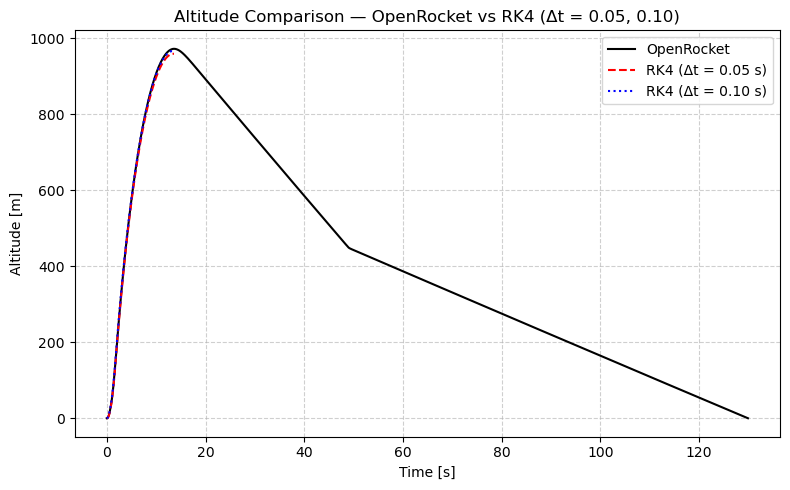

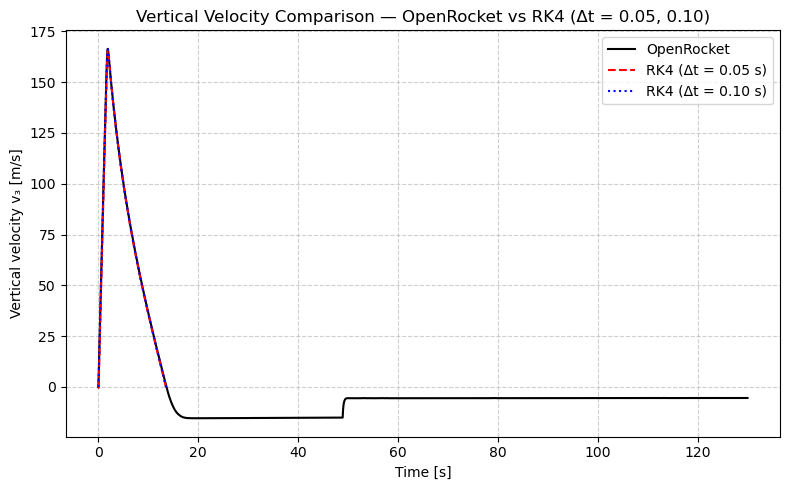

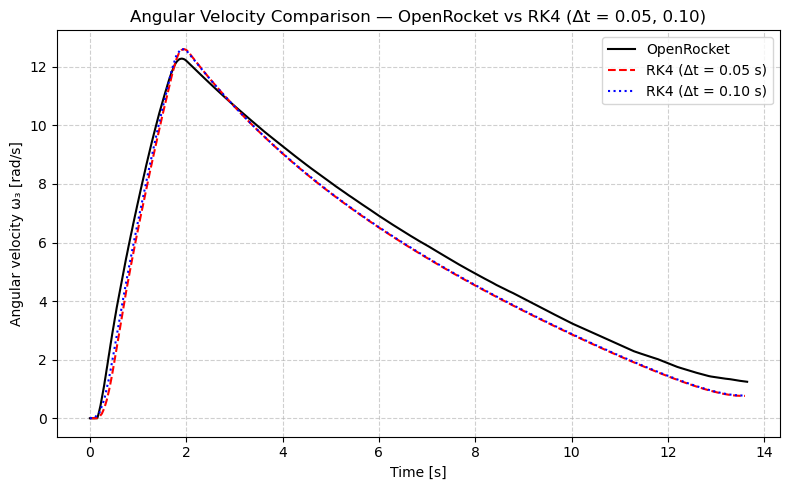

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Load all data
# ------------------------------------------------------------
or_data = pd.read_csv("../data/openrocket_data2.csv")
rk4_005 = pd.read_csv("../data/rk4_runs/rk4_dt0p050.csv")
rk4_010 = pd.read_csv("../data/rk4_runs/rk4_dt0p100.csv")

# ------------------------------------------------------------
# Extract OpenRocket data
# ------------------------------------------------------------
t_or = or_data["# Time (s)"].values
alt_or = or_data["Altitude (m)"].values
v3_or = or_data["Vertical velocity (m/s)"].values
w3_or = or_data["Roll rate (°/s)"].values * np.pi / 180  # deg/s → rad/s

# ------------------------------------------------------------
# Extract RK4 data
# ------------------------------------------------------------
t_005 = rk4_005["t"].values
v3_005 = rk4_005["v3"].values
w3_005 = rk4_005["w3"].values
dt_005 = 0.05
alt_005 = np.cumsum(v3_005) * dt_005
alt_005 -= alt_005[0]

t_010 = rk4_010["t"].values
v3_010 = rk4_010["v3"].values
w3_010 = rk4_010["w3"].values
dt_010 = 0.10
alt_010 = np.cumsum(v3_010) * dt_010
alt_010 -= alt_010[0]

# ------------------------------------------------------------
# Helper plot function
# ------------------------------------------------------------
def compare_plot(xlabel, ylabel, title, or_y, rk4a_y, rk4b_y, yscale=None):
    plt.figure(figsize=(8,5))
    plt.plot(t_or, or_y, "k-", label="OpenRocket")
    plt.plot(t_005, rk4a_y, "r--", label="RK4 (Δt = 0.05 s)")
    plt.plot(t_010, rk4b_y, "b:", label="RK4 (Δt = 0.10 s)")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, ls="--", alpha=0.6)
    if yscale:
        plt.yscale(yscale)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------
# Altitude vs time
# ------------------------------------------------------------
compare_plot(
    "Time [s]", "Altitude [m]",
    "Altitude Comparison — OpenRocket vs RK4 (Δt = 0.05, 0.10)",
    alt_or, alt_005, alt_010
)

# ------------------------------------------------------------
# Vertical velocity vs time
# ------------------------------------------------------------
compare_plot(
    "Time [s]", "Vertical velocity v₃ [m/s]",
    "Vertical Velocity Comparison — OpenRocket vs RK4 (Δt = 0.05, 0.10)",
    v3_or, v3_005, v3_010
)

# ------------------------------------------------------------
# Roll rate vs time
# ------------------------------------------------------------
compare_plot(
    "Time [s]", "Angular velocity ω₃ [rad/s]",
    "Angular Velocity Comparison — OpenRocket vs RK4 (Δt = 0.05, 0.10)",
    w3_or, w3_005, w3_010
)
